## Data cleaning

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

In [4]:
DATA_DIR = Path("raw_data")
files = sorted(DATA_DIR.glob("EURUSD_M5_*.csv"))

def read_one(fp: Path) -> pd.DataFrame:
    df = pd.read_csv(fp)
    df.columns = [c.strip().lower() for c in df.columns]
    if np.issubdtype(df['time'].dtype, np.number):
        df['time'] = pd.to_datetime(df['time'], unit='s', utc=True)
    else:
        df['time'] = pd.to_datetime(df['time'], utc=True, errors='coerce')
    keep = ['time','open','high','low','close','tick_volume','spread']
    df = df[keep]
    return df

raw = pd.concat([read_one(f) for f in files], ignore_index=True)

In [5]:
raw.shape

(1899600, 7)

In [6]:
df =raw
time_parsed = pd.to_datetime(df['time'], errors='coerce', utc=True)

summary = {
    "rows_total": len(df),
    "rows_time_parse_failed": time_parsed.isna().sum(),
    "duplicate_timestamps": time_parsed.duplicated(keep=False).sum(),
    "rows_with_any_NaN": df.isna().any(axis=1).sum(),
    "NaN_by_column": df.isna().sum().to_dict(),
}
summary

{'rows_total': 1899600,
 'rows_time_parse_failed': 0,
 'duplicate_timestamps': 0,
 'rows_with_any_NaN': 0,
 'NaN_by_column': {'time': 0,
  'open': 0,
  'high': 0,
  'low': 0,
  'close': 0,
  'tick_volume': 0,
  'spread': 0}}

In [7]:
raw = raw.sort_values('time').set_index('time')

In [8]:
raw.head()

,open,high,low,close,tick_volume,spread
time,,,,,,
2000-01-03 00:00:00+00:00,1.0073,1.0080,1.0073,1.0080,10,50
2000-01-03 00:10:00+00:00,1.0079,1.0080,1.0076,1.0077,9,50
2000-01-03 00:15:00+00:00,1.0078,1.0083,1.0076,1.0078,23,50
2000-01-03 00:20:00+00:00,1.0079,1.0082,1.0078,1.0079,9,50
2000-01-03 00:25:00+00:00,1.0082,1.0087,1.0080,1.0086,9,50


In [9]:
df = raw.copy()
print(df.index.freq) 

None


In [10]:
df.head()

,open,high,low,close,tick_volume,spread
time,,,,,,
2000-01-03 00:00:00+00:00,1.0073,1.0080,1.0073,1.0080,10,50
2000-01-03 00:10:00+00:00,1.0079,1.0080,1.0076,1.0077,9,50
2000-01-03 00:15:00+00:00,1.0078,1.0083,1.0076,1.0078,23,50
2000-01-03 00:20:00+00:00,1.0079,1.0082,1.0078,1.0079,9,50
2000-01-03 00:25:00+00:00,1.0082,1.0087,1.0080,1.0086,9,50


In [11]:
import pandas as pd
import numpy as np

# --- Assume your DataFrame is called `raw` ---
# Index: 'time' (tz-aware, UTC). Columns: ['open','high','low','close','tick_volume','spread']

# 0) Ensure a UTC, tz-aware DateTimeIndex
raw = raw.copy()
raw.index = pd.to_datetime(raw.index, utc=True)

# 2) Build the expected 5‑minute trading calendar over your data span, excluding weekends
full_idx = pd.date_range(raw.index.min(), raw.index.max(), freq="5min", tz="UTC")
full_idx = full_idx[full_idx.dayofweek < 5]

# 3) Reindex to that calendar to expose the gaps
aligned = raw.reindex(full_idx)

# 4) Report missing timestamps
missing_ts = aligned.index[aligned['close'].isna()]
n_missing = missing_ts.size

print(f"Missing 5‑min bars (weekends already excluded): {n_missing}")
# If you want a quick look at the first few gaps:
print(missing_ts[:20])


Missing 5‑min bars (weekends already excluded): 21360
DatetimeIndex(['2000-01-03 00:05:00+00:00', '2000-01-03 05:50:00+00:00',
               '2000-01-04 03:15:00+00:00', '2000-01-04 03:20:00+00:00',
               '2000-01-04 03:25:00+00:00', '2000-01-04 03:30:00+00:00',
               '2000-01-04 08:50:00+00:00', '2000-01-04 13:20:00+00:00',
               '2000-01-04 13:25:00+00:00', '2000-01-04 13:30:00+00:00',
               '2000-01-04 13:35:00+00:00', '2000-01-04 13:40:00+00:00',
               '2000-01-05 14:35:00+00:00', '2000-01-05 14:40:00+00:00',
               '2000-01-05 14:45:00+00:00', '2000-01-06 04:45:00+00:00',
               '2000-01-06 23:10:00+00:00', '2000-01-07 00:15:00+00:00',
               '2000-01-07 14:35:00+00:00', '2000-01-07 21:40:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)


In [12]:
def fill_missing_fx_ohlc(df):
    """
    Expects an index of 5‑minute UTC timestamps (weekends removed) and columns:
    open, high, low, close, tick_volume, spread
    """
    out = df.copy()
    # Identify rows that are entirely missing (e.g., after reindex)
    miss = out['close'].isna()

    # Previous close to use as flat price
    prev_close = out['close'].ffill()

    # Fill OHLC with previous close ONLY for missing bars
    for col in ['open','high','low','close']:
        out.loc[miss, col] = prev_close.loc[miss]

    # Zero out volumes on synthetic bars
    if 'tick_volume' in out.columns:
        out.loc[miss, 'tick_volume'] = 0

    # Spread: carry forward last observed value
    if 'spread' in out.columns:
        out['spread'] = out['spread'].ffill()

    # Optional: mark synthetic bars
    out['is_imputed'] = miss.astype(bool)

    return out

filled = fill_missing_fx_ohlc(aligned)


In [13]:
# 1) No remaining NaNs in price cols?
assert filled[['open','high','low','close']].isna().sum().sum() == 0

# 2) High/Low sanity: ensure low <= open/close <= high
bad = (filled['low'] > filled[['open','close','high']].min(axis=1)) | \
      (filled['high'] < filled[['open','close','low']].max(axis=1))
print("Bars with inconsistent high/low bounds:", int(bad.sum()))

# 3) Confirm constant 5‑minute spacing after weekend removal
dt = filled.index.to_series().diff().dropna()
assert (dt == pd.Timedelta(minutes=5)).all()


Bars with inconsistent high/low bounds: 0


AssertionError: 

## Feature Engineering

In [33]:
import numpy as np
import pandas as pd

def lagged_log_return(series, periods=1):
    """Log-return over given periods."""
    return np.log(series).diff(periods)

def simple_moving_average(series, window):
    """SMA over a rolling window."""
    return series.rolling(window=window).mean()

def exponential_moving_average(series, span):
    """EMA with given span."""
    return series.ewm(span=span, adjust=False).mean()

def momentum(series, window):
    """Simple price momentum: difference between current and window-period past."""
    return series.diff(window)

def rsi_wilder(series, period=14):
    """Wilder’s RSI implementation."""
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.ewm(alpha=1/period, adjust=False).mean()
    roll_down = down.ewm(alpha=1/period, adjust=False).mean()
    rs = roll_up / roll_down.replace(0, np.nan)
    return 100 - (100 / (1 + rs))

def macd(series, fast=12, slow=26, signal=9):
    """MACD line and signal line."""
    ema_fast = exponential_moving_average(series, fast)
    ema_slow = exponential_moving_average(series, slow)
    macd_line = ema_fast - ema_slow
    signal_line = exponential_moving_average(macd_line, signal)
    return macd_line, signal_line

def average_true_range(df, window=14):
    """ATR based on True Range."""
    high, low, close = df['high'], df['low'], df['close']
    prev_close = close.shift(1)
    tr = pd.concat([
        high - low,
        (high - prev_close).abs(),
        (low - prev_close).abs()
    ], axis=1).max(axis=1)
    return tr.rolling(window).mean()

def bollinger_band_width(series, window=20, n_std=2):
    """Normalized Bollinger Band width."""
    mid = simple_moving_average(series, window)
    std = series.rolling(window).std(ddof=0)
    return (2 * n_std * std) / mid

def on_balance_volume(df):
    """OBV accumulates volume on up/down moves."""
    close, volume = df['close'], df['tick_volume']
    direction = np.sign(close.diff()).fillna(0)
    return (direction * volume).cumsum()




In [35]:
data = filled.copy()
px = data['close']


In [37]:
def build_features(df):
    data = df.copy()
    px = data['close']

    # 1. Lagged returns
    data['ret_1'] = lagged_log_return(px, 1)

    # 2. Trend smoothing
    data['sma_20'] = simple_moving_average(px, 20)
    data['ema_20'] = exponential_moving_average(px, 20)

    # 3. Momentum
    data['mom_10'] = momentum(px, 10)

    # 4. Oscillators
    data['rsi_14'] = rsi_wilder(px, 14)
    data['macd'], data['macd_sig'] = macd(px, fast=12, slow=26, signal=9)

    # 5. Volatility
    data['atr_14'] = average_true_range(data, 14)
    data['bb_width_20'] = bollinger_band_width(px, 20, 2)
    data['roll_std_10'] = data['ret_1'].rolling(10).std()

    # 6. Volume proxy
    data['obv'] = on_balance_volume(data)

    # 7. Create the 1-hour forward return target
    horizon = 12  # e.g. 12 × 5-min bars = 1 hour
    data['y_ret_fwd_1h'] = np.log(data['close']).diff().rolling(horizon).sum().shift(-horizon)

    # Final cleanup and drop rows with NaNs
    return data.replace([np.inf, -np.inf], np.nan).dropna()

In [39]:
feats  = build_features(filled)


feats.columns

Index(['open', 'high', 'low', 'close', 'tick_volume', 'spread', 'is_imputed',
       'ret_1', 'sma_20', 'ema_20', 'mom_10', 'rsi_14', 'macd', 'macd_sig',
       'atr_14', 'bb_width_20', 'roll_std_10', 'obv', 'y_ret_fwd_1h'],
      dtype='object')

In [40]:
feats.shape

(1920929, 19)

In [41]:
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.inspection import permutation_importance
# import pandas as pd

# # 1) Prepare X/y
# X = feats.drop(columns=['y_ret_fwd_1h'])
# y = feats['y_ret_fwd_1h']

# # 2) Train/test split (no shuffle for time series)
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, shuffle=False
# )

# # 3) Fit RF
# rf = RandomForestRegressor(
#     n_estimators=200,
#     max_depth=10,
#     random_state=42,
#     n_jobs=-1
# )
# rf.fit(X_train, y_train)

# # 4) Impurity-based importances
# impurity_imp = pd.Series(
#     rf.feature_importances_,
#     index=X.columns
# ).sort_values(ascending=False)
# print("Top 10 features by impurity importance:")
# print(impurity_imp.head(10))

# # 5) (Optional) Permutation importances
# perm_res = permutation_importance(
#     rf,
#     X_test,
#     y_test,
#     n_repeats=10,
#     random_state=42,
#     n_jobs=-1
# )
# perm_imp = pd.Series(
#     perm_res.importances_mean,
#     index=X.columns
# ).sort_values(ascending=False)
# print("\nTop 10 features by permutation importance:")
# print(perm_imp.head(10))


## Model training

In [46]:

import os, math, random, json, time
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [47]:
plt.rcParams['figure.figsize'] = (10, 4)
RUN_DIR = Path('runs_fx_lstm')
RUN_DIR.mkdir(parents=True, exist_ok=True)

# ---- Task config ----
HORIZON_5M = 12          # next-hour (12x5min)
LOOKBACK = 48            # 4 hours context
VAL_RATIO = 0.15
TEST_RATIO = 0.15

BATCH_SIZE = 256
EPOCHS = 30
LR = 1e-3
DROPOUT_P = 0.2          # used in LSTM & MC-dropout
HIDDEN = 128
LAYERS = 1
MC_SAMPLES = 50          # MC-dropout forward passes at inference
ROLL_CONFORMAL = 2000    # rolling window for adaptive conformal
ALPHA = 0.1              # 90% PI

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(42)
print('Device:', DEVICE)

Device: cuda


In [48]:
df = feats
df = df.sort_index()
print(df.shape, df.columns[:8].tolist(), '...')
assert 'y_ret_fwd_1h' in df.columns, 'Target y_ret_fwd_1h missing from features file.'

(1920929, 19) ['open', 'high', 'low', 'close', 'tick_volume', 'spread', 'is_imputed', 'ret_1'] ...


In [49]:
N = len(df)
n_test = int(N * TEST_RATIO)
n_val  = int(N * VAL_RATIO)
n_train = N - n_val - n_test
train_df = df.iloc[:n_train]
val_df   = df.iloc[n_train:n_train+n_val]
test_df  = df.iloc[n_train+n_val:]

print('Splits:', len(train_df), len(val_df), len(test_df))

Splits: 1344651 288139 288139


In [50]:
FEATURES = [c for c in df.columns if c != 'y_ret_fwd_1h']
TARGET = 'y_ret_fwd_1h'

scaler = StandardScaler()
scaler.fit(train_df[FEATURES])

def make_xy(data, lookback=48):
    X, y, ts = [], [], []
    Xsrc = scaler.transform(data[FEATURES])
    ysrc = data[TARGET].values
    idx = data.index.values
    for i in range(lookback, len(data)-HORIZON_5M):
        X.append(Xsrc[i-lookback:i])
        y.append(ysrc[i])
        ts.append(idx[i])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32), np.array(ts)

X_tr, y_tr, ts_tr = make_xy(train_df, LOOKBACK)
X_va, y_va, ts_va = make_xy(val_df, LOOKBACK)
X_te, y_te, ts_te = make_xy(test_df, LOOKBACK)

print('Shapes:', X_tr.shape, y_tr.shape, X_va.shape, X_te.shape)

Shapes: (1344591, 48, 18) (1344591,) (288079, 48, 18) (288079, 48, 18)


In [56]:
class SeqSet(Dataset):
    def __init__(self, X, y): self.X, self.y = X, y
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return self.X[i], self.y[i]

tr_ds = SeqSet(X_tr, y_tr); va_ds = SeqSet(X_va, y_va); te_ds = SeqSet(X_te, y_te)
tr_dl = DataLoader(tr_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
va_dl = DataLoader(va_ds, batch_size=BATCH_SIZE, shuffle=False)
te_dl = DataLoader(te_ds, batch_size=BATCH_SIZE, shuffle=False)

In [58]:
class HeteroLSTM(nn.Module):
    def __init__(self, n_features, hidden=128, layers=1, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=hidden, num_layers=layers,
                            dropout=dropout if layers>1 else 0.0, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.head_mu = nn.Linear(hidden, 1)
        self.head_logvar = nn.Linear(hidden, 1)
    def forward(self, x):
        # x: (B, T, F)
        out, _ = self.lstm(x)
        h = out[:, -1, :]                 # last hidden
        h = self.dropout(h)               # enables MC-dropout at inference
        mu = self.head_mu(h).squeeze(-1)
        logvar = self.head_logvar(h).squeeze(-1)
        return mu, logvar

def gaussian_nll(y, mu, logvar):
    # NLL for Gaussian with predicted mean and log-variance
    return 0.5 * (logvar + (y - mu)**2 / torch.exp(logvar))

In [60]:
model = HeteroLSTM(n_features=len(FEATURES), hidden=HIDDEN, layers=LAYERS, dropout=DROPOUT_P).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=LR)

best = {'val_loss': float('inf')}
for epoch in range(1, EPOCHS+1):
    model.train()
    tr_loss = 0.0
    for xb, yb in tr_dl:
        xb = xb.to(DEVICE); yb = yb.to(DEVICE)
        opt.zero_grad()
        mu, logvar = model(xb)
        loss = gaussian_nll(yb, mu, logvar).mean()
        loss.backward(); opt.step()
        tr_loss += loss.item() * xb.size(0)
    tr_loss /= len(tr_ds)

    # validate
    model.eval()
    with torch.no_grad():
        va_losses = []
        for xb, yb in va_dl:
            xb = xb.to(DEVICE); yb = yb.to(DEVICE)
            mu, logvar = model(xb)
            loss = gaussian_nll(yb, mu, logvar).mean()
            va_losses.append(loss.item())
        va_loss = np.mean(va_losses)

    print(f"Epoch {epoch:02d} | train {tr_loss:.6f} | val {va_loss:.6f}")
    if va_loss < best['val_loss']:
        best = {'val_loss': va_loss, 'epoch': epoch}
        torch.save({'model': model.state_dict(), 'scaler_mean': scaler.mean_, 'scaler_scale': scaler.scale_,
                    'features': FEATURES, 'config': dict(LOOKBACK=LOOKBACK, HIDDEN=HIDDEN, LAYERS=LAYERS,
                    DROPOUT_P=DROPOUT_P)}, RUN_DIR / 'best.pth')
print('Best epoch:', best)

Epoch 01 | train -4.960394 | val -5.910591
Epoch 02 | train -5.356305 | val -5.596504
Epoch 03 | train -5.401932 | val -5.980735
Epoch 04 | train -5.413008 | val -5.520623
Epoch 05 | train -5.477972 | val -6.105634
Epoch 06 | train -5.525760 | val -4.671431
Epoch 07 | train -5.524305 | val -6.184381
Epoch 08 | train -5.574540 | val -5.939166
Epoch 09 | train -5.638571 | val -6.182448
Epoch 10 | train -5.691319 | val -6.181171
Epoch 11 | train -5.673082 | val -5.497014
Epoch 12 | train -5.834002 | val -4.976143
Epoch 13 | train -5.391141 | val -6.120081
Epoch 14 | train -5.336489 | val -6.393374
Epoch 15 | train -5.945463 | val -6.567105
Epoch 16 | train -6.145931 | val -6.668241
Epoch 17 | train -6.184228 | val -6.626001
Epoch 18 | train -6.212583 | val -6.306010
Epoch 19 | train -6.234924 | val -6.646027
Epoch 20 | train -6.251510 | val -6.558539
Epoch 21 | train -6.267710 | val -4.616877
Epoch 22 | train -6.277157 | val -6.695879
Epoch 23 | train -6.285681 | val -6.596555
Epoch 24 | 

In [65]:
ckpt = torch.load(RUN_DIR / 'best.pth', map_location=DEVICE)
model.load_state_dict(ckpt['model'])

def predict_mc_batched(model, X, mc_samples=50, batch_size=64):
    model.train()  # keep dropout ON
    mus, s2s = [], []
    device = next(model.parameters()).device

    with torch.no_grad():
        for i in range(0, len(X), batch_size):
            Xb = torch.tensor(X[i:i+batch_size], dtype=torch.float32, device=device)
            # Collect CPU-side lists per batch
            batch_mus, batch_s2s = [], []
            for _ in range(mc_samples):
                mu, logvar = model(Xb)
                batch_mus.append(mu.detach().cpu().unsqueeze(0))
                batch_s2s.append(torch.exp(logvar).detach().cpu().unsqueeze(0))
                torch.cuda.empty_cache()
            # Concatenate CPU tensors for this batch
            mus.append(torch.cat(batch_mus, dim=0))   # (K, B_batch)
            s2s.append(torch.cat(batch_s2s, dim=0))
    # Now combine all batches on CPU: 
    mu_s = torch.cat(mus, dim=1)   # (K, B_total)
    s2_s = torch.cat(s2s, dim=1)   # (K, B_total)
    mu_bar = mu_s.mean(dim=0).numpy()
    s2_alea = s2_s.mean(dim=0).numpy()
    s2_epi  = mu_s.var(dim=0, unbiased=True).numpy()
    return mu_bar, s2_alea, s2_epi, (s2_alea + s2_epi)


mu_te, s2a_te, s2e_te, s2t_te = predict_mc_batched(model, X_te, MC_SAMPLES)
mu_va, s2a_va, s2e_va, s2t_va = predict_mc_batched(model, X_va, MC_SAMPLES)

rmse = math.sqrt(mean_squared_error(y_te, mu_te))
mae  = mean_absolute_error(y_te, mu_te)
print('Test RMSE:', rmse, 'MAE:', mae)

C:\Users\hp\AppData\Local\Temp\ipykernel_30736\2110981142.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(RUN_DIR / 'best.pth', map_location=DEVICE)


Test RMSE: 0.0010680838350381047 MAE: 0.000694973801728338


In [67]:
# Compute absolute residuals on validation
res_val = np.abs(y_va - mu_va)

def rolling_quantile(scores, q=0.9, window=2000):
    # returns array of same length with rolling quantile; first window uses expanding
    from collections import deque
    out = np.empty_like(scores); out[:] = np.nan
    dq = deque()
    for i, s in enumerate(scores):
        dq.append(float(s))
        if len(dq) > window: dq.popleft()
        out[i] = np.quantile(dq, q)
    return out

q_val = rolling_quantile(res_val, q=1-ALPHA, window=ROLL_CONFORMAL)
q_star = np.nanmedian(q_val)  # baseline constant radius from validation
print('Baseline conformal radius (validation):', q_star)

# Adaptive on test: update radius with rolling residuals
res_te_hist = []
q_te = np.empty_like(y_te)
for i in range(len(y_te)):
    # update with previous residual if available
    if i > 0:
        res_te_hist.append(abs(y_te[i-1] - mu_te[i-1]))
        if len(res_te_hist) > ROLL_CONFORMAL:
            res_te_hist.pop(0)
    q_adapt = np.quantile(res_te_hist, 1-ALPHA) if res_te_hist else q_star
    q_te[i] = q_adapt

# Conformal intervals centered at mean prediction
lo_cqr = mu_te - q_te
hi_cqr = mu_te + q_te

# Gaussian-based intervals using total variance (for comparison)
z = float(scipy.stats.norm.ppf(1-ALPHA/2)) if False else 1.6448536269514722  # 90%
lo_gau = mu_te - z*np.sqrt(s2t_te)
hi_gau = mu_te + z*np.sqrt(s2t_te)

def coverage(y, lo, hi):
    return np.mean((y >= lo) & (y <= hi))

cov_cqr = coverage(y_te, lo_cqr, hi_cqr)
cov_gau = coverage(y_te, lo_gau, hi_gau)
print('PI coverage | Conformal (target≈90%):', cov_cqr, '| Gaussian:', cov_gau)

Baseline conformal radius (validation): 0.0012324941
PI coverage | Conformal (target≈90%): 0.8984028686575557 | Gaussian: 0.9143394693816627


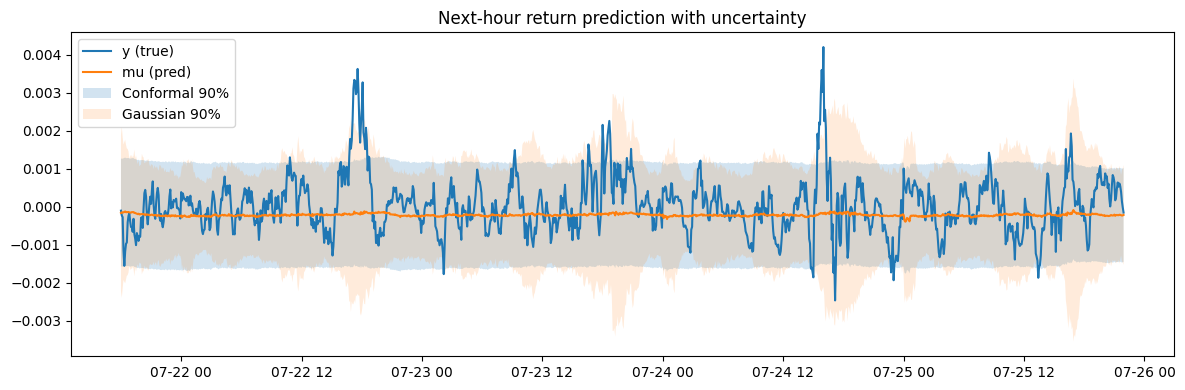

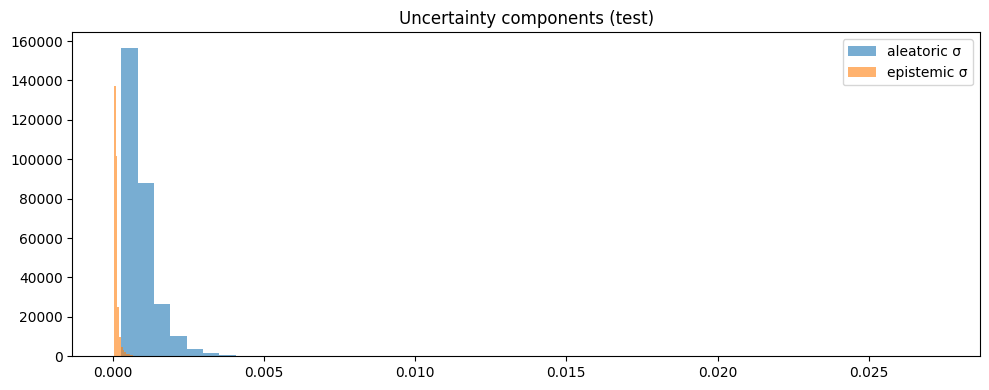

In [69]:

# Plot a recent window
W = 1200
idx = slice(-W, None)
t_idx = pd.to_datetime(ts_te[idx])

plt.figure(figsize=(12,4))
plt.plot(t_idx, y_te[idx], label='y (true)')
plt.plot(t_idx, mu_te[idx], label='mu (pred)')
plt.fill_between(t_idx, lo_cqr[idx], hi_cqr[idx], alpha=0.2, label='Conformal 90%')
plt.fill_between(t_idx, (mu_te - 1.645*np.sqrt(s2t_te))[idx], (mu_te + 1.645*np.sqrt(s2t_te))[idx], 
                 alpha=0.15, label='Gaussian 90%')
plt.legend(); plt.title('Next-hour return prediction with uncertainty'); plt.tight_layout(); plt.show()

# Uncertainty decomposition histogram
plt.figure()
plt.hist(np.sqrt(s2a_te), bins=50, alpha=0.6, label='aleatoric σ')
plt.hist(np.sqrt(s2e_te), bins=50, alpha=0.6, label='epistemic σ')
plt.legend(); plt.title('Uncertainty components (test)'); plt.tight_layout(); plt.show()

In [73]:
# Save predictions and intervals
out = pd.DataFrame({
    'time': pd.to_datetime(ts_te),
    'y': y_te, 'mu': mu_te,
    'sigma_alea': np.sqrt(s2a_te),
    'sigma_epi':  np.sqrt(s2e_te),
    'lo_cqr': lo_cqr, 'hi_cqr': hi_cqr
}).set_index('time')

# Minimal inference helper
def predict_next_hour(feature_matrix, model_path=RUN_DIR/'best.pth'):
    ck = torch.load(model_path, map_location='cpu')
    feats = ck['features']
    sc = StandardScaler(); sc.mean_ = ck['scaler_mean']; sc.scale_ = ck['scaler_scale']
    X = sc.transform(feature_matrix[feats])[-LOOKBACK:][None].astype('float32')
    m = HeteroLSTM(n_features=len(feats), hidden=HIDDEN, layers=LAYERS, dropout=DROPOUT_P)
    m.load_state_dict(ck['model']); m.eval()
    with torch.no_grad():
        mu, logvar = m(torch.tensor(X))
        mu = mu.item(); s2 = float(torch.exp(logvar).item())
    return mu, math.sqrt(s2)